# DCGANでポケモンを生成する

In [1]:
import torch
from torch import nn, optim
import torchvision.utils as vutils
from torchvision import transforms
import numpy as np
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [2]:
img_size = 64 # 画像サイズ
batch_size = 64 # バッチサイズ
lr = 0.0001 # 学習率
nz = 100 # 潜在ベクトルの次元数


---

## データ読み込み

In [3]:
import os
from PIL import Image

img_path = sorted(os.listdir('./data'))
images = []
for path in img_path:
    img = Image.open('data/' + path)
    img = img.resize((img_size, img_size)).convert('RGB')
    images.append(np.array(img) / 255.)

images = np.array(images)
images = np.transpose(images, (0, 3, 1, 2))
images = torch.tensor(images, dtype=torch.float32).to(device)
images.shape

torch.Size([819, 3, 64, 64])


---

## 描画

In [4]:
from IPython.display import display

def draw(imgs, nrow=10):
    img = vutils.make_grid(imgs, nrow=nrow)
    img = transforms.functional.to_pil_image(img)
    display(img)

def write(generator, n_images):
    noise = torch.randn(n_images, nz, 1, 1).to(device)
    img = generator(noise)
    return img

def write_draw(generator, n_images, nrow):
    img = write(generator, n_images)
    draw(img, nrow)

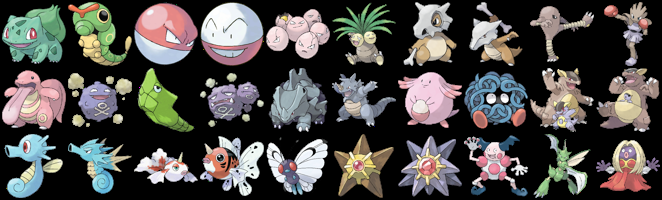

In [5]:
draw(images[:30])


---

## ネットワーク構築

### Generator

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            self.convT( nz, 512, 4, 1, 0), # ( 4,  4)
            self.convT(512, 256, 4, 2, 1), # ( 8,  8)
            self.convT(256, 128, 4, 2, 1), # (16, 16)
            self.convT(128,  64, 4, 2, 1), # (32, 32)
            nn.ConvTranspose2d(64, 3, 4, 2, 1), # (64, 64)
            nn.Tanh()
        )

    def convT(self, in_channels, out_channels, kernel_size, stride, padding):
        net = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU()
        )
        return net

    def forward(self, x):
        y = self.net(x)
        return y

### Discriminator

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            self.conv(  3,   64, 4, 2, 1), # (32, 32)
            self.conv( 64,  128, 4, 2, 1), # (16, 16)
            self.conv(128,  256, 4, 2, 1), # ( 8,  8)
            self.conv(256,  512, 4, 2, 1), # ( 4,  4)
            self.conv(512, 1024, 4, 2, 1), # ( 2,  2)
            nn.Conv2d(1024,   1, 4, 2, 1), # ( 1,  1)
            nn.Flatten(),
            nn.Sigmoid()
        )

    def conv(self, in_channels, out_channels, kernel_size, stride, padding):
        net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU()
        )
        return net

    def forward(self, x):
        y = self.net(x)
        return y


---

## 学習

### 諸々の定義

In [8]:
netD = Discriminator().to(device)
netG = Generator().to(device)

optimD = optim.Adam(netD.parameters(), lr=lr)
optimG = optim.Adam(netG.parameters(), lr=lr)

label_real = torch.ones((batch_size, 1)).to(device)
label_fake = torch.zeros((batch_size, 1)).to(device)

criterion = nn.BCELoss()

n_per_epoch = int(len(images) / batch_size) + 1
n_images = len(images)

### 1epoch で行うこと

関数化

In [9]:
def train(imgs):
    # ----------- Discriminator train -----------
    netD.zero_grad()

    y_real = netD(imgs)
    lossD_real = criterion(y_real, label_real)

    noise = torch.randn(batch_size, nz, 1, 1).to(device)
    fake = netG(noise)
    y_fake = netD(fake)
    lossD_fake = criterion(y_fake, label_fake)

    lossD = lossD_real + lossD_fake
    lossD.backward(retain_graph=True)
    optimD.step()

    # ----------- Generator train -----------
    netG.zero_grad()

    y_fake = netD(fake)
    lossG = criterion(y_fake, label_real)
    lossG.backward(retain_graph=True)
    optimG.step()

    return lossD, lossG

### 学習

In [10]:
n_epochs = 100
epoch_per_print = 10
epoch_per_draw = 10

# img_log = []

初期状態


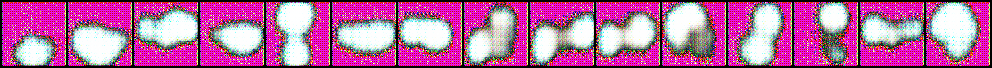

10 epoch lossD:0.021974166855216026, lossG:9.952980041503906


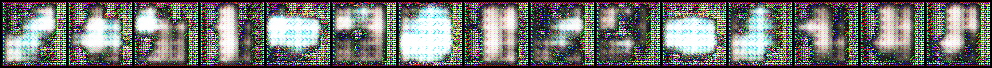

20 epoch lossD:0.1712852567434311, lossG:5.490546226501465


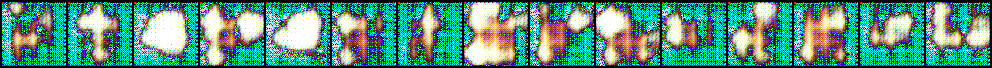

30 epoch lossD:0.04224320501089096, lossG:4.83401346206665


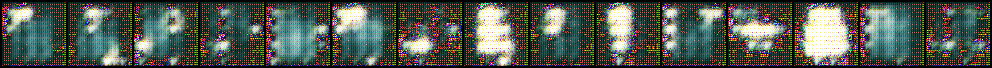

In [13]:
print('初期状態')
write_draw(netG, 15, 15)
for epoch in range(n_epochs):
    epoch += 1
    for _ in range(n_per_epoch):
        idx = torch.randint(0, n_images, (batch_size,))
        sample_img = images[idx]
        lossD, lossG = train(sample_img)
    # img = write(netG, 15).cpu()
    # img_log.append(img)

    if not (epoch) % epoch_per_print:
        print(f'{epoch: >2} epoch lossD:{lossD}, lossG:{lossG}')
    if not (epoch) % epoch_per_draw:
        write_draw(netG, 15, 15)